# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV    
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

import warnings

In [2]:
RANDOM_STATE = 12345

In [3]:
warnings.filterwarnings("ignore")

## Подготовка данных

### Предоработка данных

In [4]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Для начала проверим явные дубликаты и если они есть уберем их из датасета

In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates().reset_index(drop=True)

Избавимся от колонок, которые не влияют на ценообразование автомобиля

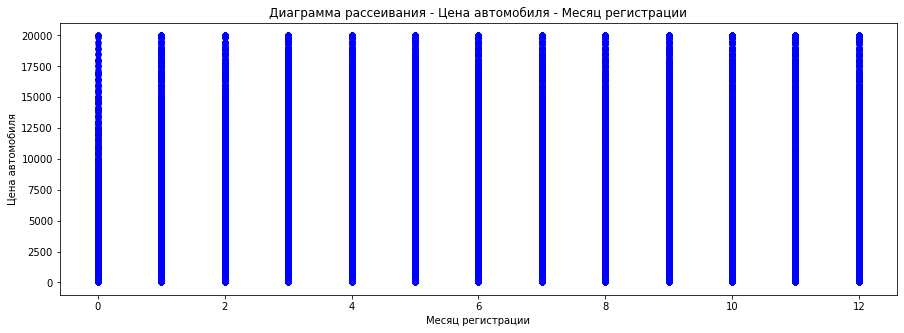

In [8]:
df.plot(x='RegistrationMonth', y='Price', kind='scatter', figsize=(15,5), c = 'b');
plt.ylabel('Цена автомобиля');
plt.xlabel('Месяц регистрации');
plt.title('Диаграмма рассеивания - Цена автомобиля - Месяц регистрации');

In [9]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

In [10]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Найдено большое количесво пропусков, просто удалить их не получится.

В столбце 'Repaired' много пропусков можно предположить, что машина не была в ремонте.

Остальные столбцы заполним модами, т.к. это категориальные переменные.

In [11]:
df['Repaired'] = df['Repaired'].fillna('no')

In [12]:
df["VehicleType"] = df["VehicleType"].fillna(df["VehicleType"].mode().values[0])
df["Gearbox"] = df["Gearbox"].fillna(df["Gearbox"].mode().values[0])
df["Model"] = df["Model"].fillna(df["Model"].mode().values[0])
df["FuelType"] = df["FuelType"].fillna(df["FuelType"].mode().values[0])

In [13]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Теперь необходимо избавиться от выбросов

In [14]:
df.shape

(354365, 10)

In [15]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [16]:
def bxplt(column, minlim, maxlim, name):
    plt.figure(figsize=(15,5))
    sns.boxplot(data=df[column], orient='h')
    plt.grid()
    plt.ylabel(column)
    plt.xlabel(name)
    plt.title(f'Диаграмма размаха признака: {column}')
    plt.xlim(minlim, maxlim)
    plt.show();

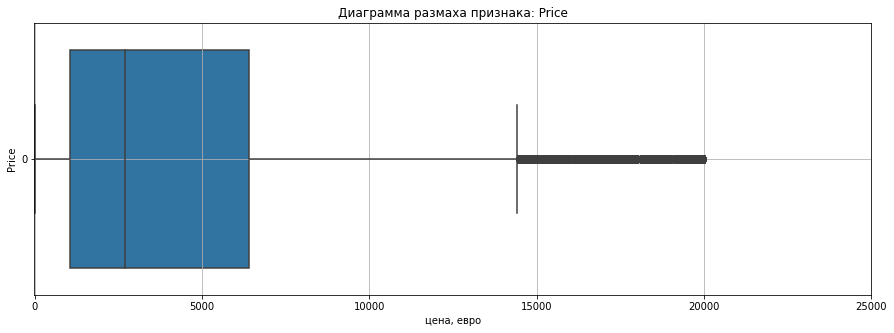

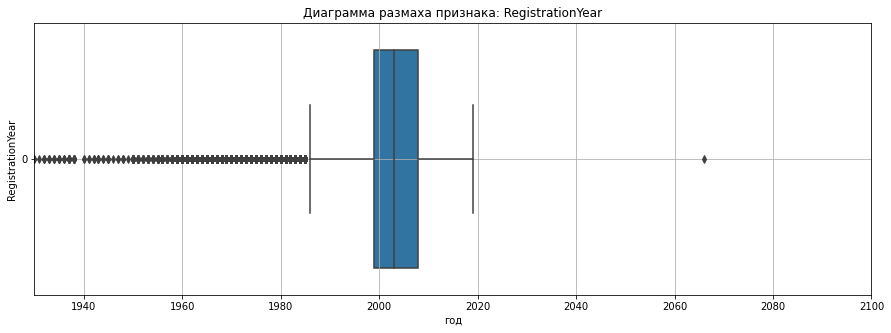

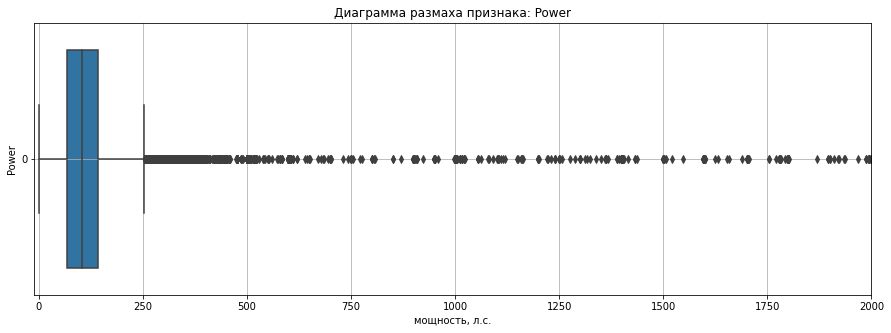

In [17]:
bxplt('Price', -10,25000, 'цена, евро')
bxplt('RegistrationYear', 1930, 2100, 'год')
bxplt('Power', -10, 2000, 'мощность, л.с.')

In [18]:
df = df.loc[(df['Price'] < 16000) & (df['RegistrationYear'] > 5)]

In [19]:
df = df.loc[(df['RegistrationYear'] < 2017) & (df['RegistrationYear'] > 1970)]

In [20]:
df = df.loc[(df['Power'] < 1000) & (df['Power'] > 5)]
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,291047.000000,291047.000000,291047.000000,291047.000000
mean,4244.738207,2002.620577,118.275248,129969.626899
std,3892.972158,6.110856,52.506131,35456.270086
min,0.000000,1971.000000,6.000000,5000.000000
25%,1200.000000,1999.000000,75.000000,125000.000000
50%,2900.000000,2003.000000,109.000000,150000.000000
75%,6300.000000,2007.000000,144.000000,150000.000000
max,15999.000000,2016.000000,999.000000,150000.000000


In [21]:
df.shape

(291047, 10)

Убрали все выбросы.

In [22]:
df.duplicated().sum()

48684

In [23]:
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(242363, 10)

### Разбиение данных

Будем использовать кросс-валидацию, поэтому валидационная выборка не нужна

In [24]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

features = df.drop(['Price'], axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=RANDOM_STATE)

## Обучение моделей

### CatBoost

In [25]:
train_pool = Pool(data=features_train,
                  label=target_train,
                  cat_features=cat_features
                 )

catboost = CatBoostRegressor(loss_function='RMSE', verbose=20, random_state=RANDOM_STATE)

parameters_cat = {'depth':[5,10], 
                  'learning_rate':np.arange(0.1,1,0.2),
                  'iterations': range(20, 60, 20)}

In [26]:
catboost_grid = catboost.grid_search(parameters_cat, train_pool,
            cv=3,
            verbose=True,
            plot=False)

0:	learn: 5413.9260442	test: 5404.3632884	best: 5404.3632884 (0)	total: 113ms	remaining: 2.14s
19:	learn: 2177.6299002	test: 2170.2006131	best: 2170.2006131 (19)	total: 994ms	remaining: 0us

bestTest = 2170.200613
bestIteration = 19

0:	loss: 2170.2006131	best: 2170.2006131 (0)	total: 1.98s	remaining: 37.5s
0:	learn: 4501.5809254	test: 4496.0957113	best: 4496.0957113 (0)	total: 53.6ms	remaining: 1.02s
19:	learn: 1798.2040272	test: 1790.1918626	best: 1790.1918626 (19)	total: 917ms	remaining: 0us

bestTest = 1790.191863
bestIteration = 19

1:	loss: 1790.1918626	best: 1790.1918626 (1)	total: 2.92s	remaining: 26.3s
0:	learn: 3671.3144899	test: 3670.3285374	best: 3670.3285374 (0)	total: 53.3ms	remaining: 1.01s
19:	learn: 1757.7935848	test: 1754.5967831	best: 1754.5967831 (19)	total: 907ms	remaining: 0us

bestTest = 1754.596783
bestIteration = 19

2:	loss: 1754.5967831	best: 1754.5967831 (2)	total: 3.85s	remaining: 21.8s
0:	learn: 2992.2486265	test: 2996.0717956	best: 2996.0717956 (0)	total:

In [27]:
catboost_rmse = min(catboost_grid['cv_results']['test-RMSE-mean'])
print('RMSE catboost:', catboost_rmse)

RMSE catboost: 1612.0896597832495


In [28]:
model_cb = CatBoostRegressor(loss_function='RMSE', 
                             verbose=20, 
                             random_state=RANDOM_STATE,
                             **catboost_grid['params']
                            )

In [29]:
%%time
model_cb.fit(train_pool)

0:	learn: 2754.3576514	total: 114ms	remaining: 4.46s
20:	learn: 1592.7392104	total: 1.95s	remaining: 1.77s
39:	learn: 1522.6792795	total: 3.83s	remaining: 0us
CPU times: user 3.95 s, sys: 31.5 ms, total: 3.98 s
Wall time: 4.63 s


In [30]:
%%time
predict_train = model_cb.predict(features_train)

CPU times: user 244 ms, sys: 7.98 ms, total: 252 ms
Wall time: 255 ms


###  LightGBM

In [31]:
for col in features.select_dtypes(include=['object']):
  features[col] = features[col].astype('category')

In [32]:
features_train_lgb, features_test_lgb, target_train_lgb, target_test_lgb = train_test_split(
    features, target, test_size=.25, random_state=RANDOM_STATE)

In [33]:
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'n_estimators': 100,
    'random_state': RANDOM_STATE,
    'categorical_feature': cat_features
}
lgbm_regressor = lgb.LGBMRegressor(**params)

In [34]:
cv_results = lgb.cv(
    params, 
    lgb.Dataset(features_train_lgb, label=target_train_lgb), 
    num_boost_round=1000, 
    nfold=5, 
    early_stopping_rounds=50, 
    verbose_eval=10, 
    seed=42
)

[LightGBM] [Warning] categorical_feature is set=VehicleType,Gearbox,Model,FuelType,Brand,Repaired, categorical_column=0,2,4,6,7,8 will be ignored. Current value: categorical_feature=VehicleType,Gearbox,Model,FuelType,Brand,Repaired
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 145417, number of used features: 9
[LightGBM] [Warning] categorical_feature is set=VehicleType,Gearbox,Model,FuelType,Brand,Repaired, categorical_column=0,2,4,6,7,8 will be ignored. Current value: categorical_feature=VehicleType,Gearbox,Model,FuelType,Brand,Repaired
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

In [35]:
print('RMSE lgbm:', min(cv_results['rmse-mean']))

RMSE lgbm: 1575.9524574925767


In [36]:
model_lgb = lgb.LGBMRegressor(**params)

In [37]:
%%time
model_lgb.fit(features_train_lgb, target_train_lgb)

CPU times: user 32.7 s, sys: 144 ms, total: 32.9 s
Wall time: 33.3 s


LGBMRegressor(categorical_feature=['VehicleType', 'Gearbox', 'Model',
                                   'FuelType', 'Brand', 'Repaired'],
              metric='rmse', objective='regression', random_state=12345)

In [38]:
%%time
model_lgb.predict(features_train_lgb)

CPU times: user 2.21 s, sys: 0 ns, total: 2.21 s
Wall time: 2.2 s


array([1363.34742861, 1251.2818344 , 2541.08294692, ...,  950.99242057,
       1384.13606826, 8315.65384781])

### DecisionTreeRegressor

In [39]:
features_train_encoder = features_train.copy()
features_test_encoder = features_test.copy()

In [ ]:
encoder = OrdinalEncoder()

In [40]:
encoder.fit(features_train_encoder[cat_features])
features_train_encoder[cat_features] = encoder.transform(features_train_encoder[cat_features])
features_test_encoder[cat_features] = encoder.transform(features_test_encoder[cat_features])
features_train_encoder.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
132866,5.0,2002,1.0,75,75.0,150000,6.0,27.0,0.0
82045,7.0,2000,1.0,125,139.0,150000,6.0,34.0,0.0
123611,2.0,2000,1.0,169,75.0,150000,6.0,27.0,0.0
1939,3.0,2011,1.0,122,199.0,125000,6.0,38.0,0.0
71905,5.0,2005,1.0,131,173.0,150000,2.0,38.0,0.0


In [41]:
dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters = {"splitter":["random"],
              "max_depth" : [7,9],
              "min_samples_leaf":[4,6],
              "max_features":["sqrt",None],
              "max_leaf_nodes":[None,10,30]
             }

In [42]:
dtr_tuned = GridSearchCV(dtr_model,
                         param_grid=parameters,
                         scoring='neg_root_mean_squared_error',
                         cv=3,verbose=3, 
                         n_jobs=-1)

dtr_tuned.fit(features_train_encoder, target_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END max_depth=7, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, splitter=random; total time=   0.1s
[CV 2/3] END max_depth=7, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, splitter=random; total time=   0.1s
[CV 3/3] END max_depth=7, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, splitter=random; total time=   0.0s
[CV 1/3] END max_depth=7, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, splitter=random; total time=   0.1s
[CV 2/3] END max_depth=7, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, splitter=random; total time=   0.1s
[CV 3/3] END max_depth=7, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=6, splitter=random; total time=   0.1s
[CV 1/3] END max_depth=7, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, splitter=random; total time=   0.0s
[CV 2/3] END max_depth=7, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, spl

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [7, 9], 'max_features': ['sqrt', None],
                         'max_leaf_nodes': [None, 10, 30],
                         'min_samples_leaf': [4, 6], 'splitter': ['random']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [43]:
dtr_tuned.best_params_

{'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 4,
 'splitter': 'random'}

In [44]:
print('RMSE dtr:', abs(dtr_tuned.cv_results_['mean_test_score'].mean()))

RMSE dtr: 2926.59792302078


In [45]:
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE, **dtr_tuned.best_params_)

In [46]:
%%time
model_dt.fit(features_train_encoder, target_train)

CPU times: user 121 ms, sys: 119 µs, total: 121 ms
Wall time: 120 ms


DecisionTreeRegressor(max_depth=9, min_samples_leaf=4, random_state=12345,
                      splitter='random')

In [47]:
%%time
model_dt.predict(features_train_encoder)

CPU times: user 22.4 ms, sys: 66 µs, total: 22.5 ms
Wall time: 20.5 ms


array([2457.9419985 , 2298.29755234, 2298.29755234, ..., 1168.88013319,
       1479.32115385, 9030.36450584])

## Анализ моделей

Наилучший показатель по времени дала модель DecisionTreeRegressor, но с самой плохой метрикой, поэтому для оптимальной метрики и времени обучения выберем CatBoost и проверим на тестовой выборке

In [48]:
data = {'Время обучения': ['4.79 s', '4.96 s', '118 ms'],
        'Время предсказания': ['243 ms', '2.02 s', '21.2 ms'],
        'RMSE': [1612.09, 1575.9, 2926.5]}

pd.DataFrame(data, index=['CatBoost', 'LightGBM', 'DecisionTreeRegressor'])

,Время обучения,Время предсказания,RMSE
CatBoost,4.79 s,243 ms,1612.09
LightGBM,4.96 s,2.02 s,1575.90
DecisionTreeRegressor,118 ms,21.2 ms,2926.50


In [49]:
catboost_grid['params']

{'depth': 10, 'iterations': 40, 'learning_rate': 0.5000000000000001}

In [50]:
test_pool = Pool(data=features_test,
                  label=target_test,
                  cat_features=cat_features
                 )

In [51]:
cb_model = CatBoostRegressor(loss_function='RMSE', **catboost_grid['params'])
cb_model.fit(train_pool, eval_set=test_pool)

0:	learn: 2732.5874475	test: 2741.1108034	best: 2741.1108034 (0)	total: 149ms	remaining: 5.82s
1:	learn: 2222.0085880	test: 2229.2682360	best: 2229.2682360 (1)	total: 257ms	remaining: 4.89s
2:	learn: 1971.4695402	test: 1977.2122365	best: 1977.2122365 (2)	total: 377ms	remaining: 4.65s
3:	learn: 1839.5720020	test: 1847.7431581	best: 1847.7431581 (3)	total: 488ms	remaining: 4.39s
4:	learn: 1771.7117834	test: 1779.6869492	best: 1779.6869492 (4)	total: 596ms	remaining: 4.17s
5:	learn: 1744.1607598	test: 1753.8335070	best: 1753.8335070 (5)	total: 687ms	remaining: 3.89s
6:	learn: 1720.9357987	test: 1733.1951831	best: 1733.1951831 (6)	total: 780ms	remaining: 3.68s
7:	learn: 1703.5515332	test: 1717.7557591	best: 1717.7557591 (7)	total: 874ms	remaining: 3.5s
8:	learn: 1688.3240280	test: 1704.4015469	best: 1704.4015469 (8)	total: 965ms	remaining: 3.33s
9:	learn: 1673.3164143	test: 1691.7523606	best: 1691.7523606 (9)	total: 1.06s	remaining: 3.17s
10:	learn: 1663.8222843	test: 1683.9682940	best: 16

In [52]:
print('RMSE CatBoost:', cb_model.best_score_['validation']['RMSE'])

RMSE CatBoost: 1594.910135913084


In [53]:
dummy_model = DummyRegressor()
dummy_model.fit(features_train_encoder, target_train)
dummy_predictions = dummy_model.predict(features_test_encoder)
mse = mean_squared_error(target_test, dummy_predictions)
print('Метрика RMSE для dummy: ', mse ** 0.5)

Метрика RMSE для dummy:  3946.3161461978098


Выбранная модель почти в 2 раза лучше константной

## Вывод

В ходе проекта:

- была проведена обработка даннных (устранены выбросы, удалены дубликаты и тд)
- была выбранная лучшая модель по соотношению скорости и метрики, это CatBoost
- для проверки модели дерева решений, было применено порядковое кодироване
- финальный результат проверили на адекватность, сравнив с константной моделью